# Conbining different MBTI Models - Most Frequent Prediction Method

By: Sara Jakša

In this project, we are going to be combining different models or order to bust our prediction rate.

In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
%matplotlib inline

/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


This part is here because it is a value that I am frequently using in the script.

In [2]:
filenames = ["ENFJ",
             "ENFP",
             "ENTJ",
             "ENTP",
             "ESFJ",
             "ESFP",
             "ESTJ",
             "ESTP",
             "INFJ",
             "INFP",
             "INTJ",
             "INTP",
             "ISFJ",
             "ISFP",
             "ISTJ",
             "ISTP"]

This function here is used to get all the different data for each different label. 

In [3]:
def get_type_texts(filename):
    posts = []
    with open("PersonalityCafePosts/" + filename, "r") as read:
        content = read.readlines()
    content = "".join(content)
    content = content.split("\n\n\n")
    content = [post.strip() for post in content]
    posts = posts + content
    with open("Reddit/reddit.csv", "r") as read:
        content = read.readlines()
    for line in content:
        typename = line.split("\t")
        if typename[2].strip().lower() == filename.lower():
            posts.append(line.strip())
    if filename in ["ESFJ"]:
        with open("Tumblr/" + filename.lower() + "-posts.csv", "r") as read:
            content = read.readlines()
            posts = posts + content
    return posts

This function let us get the number selection of the posts. It is used in order to create submodels which will have balaned data.

In [4]:
def get_random_posts(typename, number_of_posts):
    posts = get_type_texts(typename)
    return random.sample(posts, number_of_posts)

This function simply allows us to check how many instances of each type are there.

In [5]:
def get_number_of_texts():
    typeposts = defaultdict(int)
    for filename in filenames:
        typeposts[filename] = len(get_type_texts(filename))
    return typeposts

Next we will check how many element does the category with least elements has.

In [6]:
min_data = min([element for element in get_number_of_texts().values()])
print(min_data)

1360


This function will allow us to create a model, test it on a seperate part of the data and the output the model. 

In [7]:
def create_model(min_data, function_used, ngram_range_value=(1,2)):
    all_data = []
    all_labels = []
    for filename in filenames:
        current_data = get_random_posts(filename, min_data)
        all_data = all_data + current_data
        all_labels = all_labels + [filename]*len(current_data)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(all_data, all_labels, test_size=0.25)
    model = Pipeline([('vect', CountVectorizer(stop_words="english", ngram_range=ngram_range_value)),
                  ('tfidf', TfidfTransformer()),
                  ('fitting', function_used),
                  ])
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print(np.mean(predicted == y_test))
    return model

This is going to be the list where we will keep track of all the models.

In [8]:
all_models = []

Now we are going to be creating the models and saving them in the all_models variable.

In [9]:
for i in range(1):
    all_models.append(create_model(min_data, LogisticRegression()))
    all_models.append(create_model(min_data, SGDClassifier()))
    all_models.append(create_model(min_data, MultinomialNB()))
    all_models.append(create_model(min_data, RandomForestClassifier()))
    all_models.append(create_model(min_data, DecisionTreeClassifier()))
    all_models.append(create_model(min_data, LinearSVC()))

0.352205882353
0.356801470588
0.26875
0.254044117647
0.272242647059
0.361397058824


Now we are going to save these models in the "mbti-16-models.obj" file, so that we will not need to calculate them every single time.

In [10]:
with open("mbti-6-models.obj", "wb") as output_file:
    for model in all_models[:7]:
        pickle.dump(model, output_file)

The next function will simply take the dictionary with all predictions and output the most frequent one.

In [11]:
def get_most_frequent_pred(dictionary):
    most_freq_num = 0
    most_freq_type = ""
    for typename, freq in dictionary.items():
        if freq > most_freq_num:
            most_freq_num = freq
            most_freq_type = typename
    return most_freq_type

The next part is simply to test how well the combined models do.

In [12]:
all_data = []
all_labels = []
for filename in filenames:
    current_data = get_random_posts(filename, min_data)
    all_data = all_data + current_data
    all_labels = all_labels + [filename]*len(current_data)

In [13]:
whole_data = list(zip(all_data, all_labels))
random.shuffle(whole_data)
all_data = [d[0] for d in whole_data]
all_labels = [d[1] for d in whole_data]

In [14]:
predicted = []
i = 0
for data in all_data[:500]:
    i += 1
    all_pred = defaultdict(int)
    for model in all_models[:50]:
        something = []
        something.append(data)
        pred = model.predict(something)
        all_pred[pred[0]] += 1
    pred = get_most_frequent_pred(all_pred)
    predicted.append(pred)

In [15]:
print(np.mean([1 if x == y else 0 for x, y in zip(predicted, all_labels[:500])]))

0.502


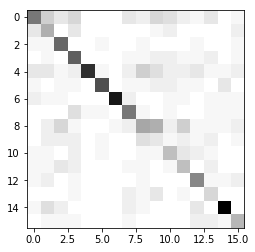

In [16]:
conf = confusion_matrix(predicted, all_labels[:500])
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()

Now if a person just want to import an use them, the the following function can be use.

In [20]:
models = []

In [21]:
with open("mbti-6-models.obj", "rb") as f:
    for i in range(6):
        models.append(pickle.load(f))

And then text can be predicted in the following way:

In [32]:
all_pred = defaultdict(int)

In [33]:
for model in models:
    prediction = model.predict(["""The third-rate mind is only happy when it is thinking with the majority. 
                                The second-rate mind is only happy when it is thinking with the minority. 
                                The first-rate mind is only happy when it is thinking."""])
    all_pred[prediction[0]] += 1

In [34]:
get_most_frequent_pred(all_pred)

'ESFJ'